In [1]:
# load both dataframes
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

original_df = pd.read_csv("./spreadsheets/reflacx_clinical.csv")
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
]
chexpert_label_cols = [col for col in original_df if col.endswith("chexpert")]
auged_features = []
extended_clinical_features = original_clinical_cols + []

In [2]:
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
import torch


def get_acc_auc(df, input_cols, label_cols, cls):
    cls = cls.fit(
        df[df["split"] == "train"][input_cols],
        df[df["split"] == "train"][label_cols],
    )

    pred = cls.predict(df[df["split"] == "test"][original_clinical_cols])

    mla = MultilabelAccuracy(num_labels=len(chexpert_label_cols), average="micro")
    acc = mla(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).float(),
    )

    ml_auroc = MultilabelAUROC(num_labels=len(chexpert_label_cols), average="micro")
    auc = ml_auroc(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).long(),
    )

    feature_importance_dict = {
        c: i for c, i in zip(original_clinical_cols, cls.feature_importances_)
    }
    return feature_importance_dict, acc, auc

In [7]:
rf_fi, rf_acc, rf_auc = get_acc_auc(original_df, original_clinical_cols, chexpert_label_cols, RandomForestClassifier())

In [14]:
tr_fi, tr_acc, tr_auc =get_acc_auc(original_df, original_clinical_cols, chexpert_label_cols, DecisionTreeClassifier())
tr_fi, tr_acc, tr_auc

({'temperature': 0.1959343325506267,
  'heartrate': 0.19756715439384445,
  'resprate': 0.06896893914749759,
  'o2sat': 0.10162402829359589,
  'sbp': 0.22925800592404355,
  'dbp': 0.20664753969039196},
 tensor(0.8792),
 tensor(0.6624))

In [10]:
pd.DataFrame([rf_fi])

,temperature,heartrate,resprate,o2sat,sbp,dbp
0,0.179844,0.19902,0.097702,0.108819,0.213383,0.201232


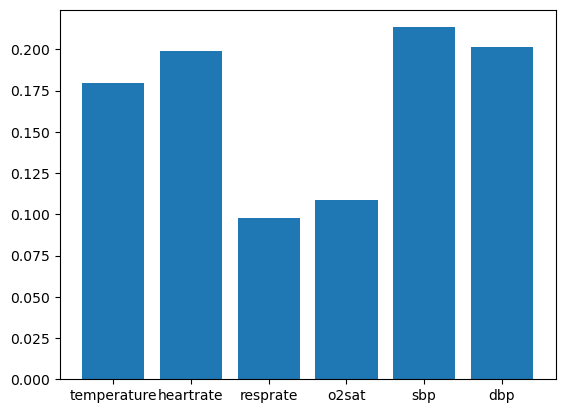

In [13]:
plt.bar(
    list(rf_fi.keys()),
    list(rf_fi.values()),
)
plt.show()

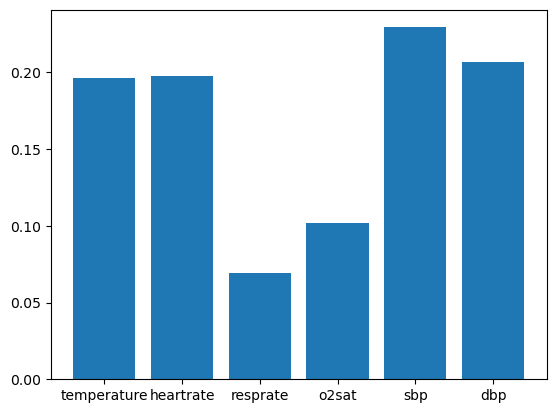

In [15]:
plt.bar(
    list(tr_fi.keys()),
    list(tr_fi.values()),
)
plt.show()